# Environmental Masking

Light changes from the sun and moon can present a problem for background subtraction. For the Sky360 application this may result in issues with tracking, particularly in complex scenes with the presence of partial cloud.

To illustrate this the images below show a frame of the foreground mask produced by ViBE BGS in day and night conditions. In both cases the changes in the foreground mask (white pixels) are due to complex light changes as the low clouds pass in front of the light source. Note the complexity of the day example in particular where diffuse light causes significant noise in the foreground mask around the cloud edges. The night example is not as severe but still exhibits motion changes around the moon's position. 

<img src="day_vibe.PNG" width="450">
<img src="night_vibe.PNG" width="450">

The idea in this script is to explore masking of the sun and moon as a means to reduce this issue. The hope is this will be another tool to help with tracker accuracy and reduce false positives in detection.

First, some imports and a function for helping with blurring of the edges around the solar mask...

In [31]:
import cv2
import datetime
import dateutil
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ephem

def alphaBlend(img1, img2, mask):
    if mask.ndim==3 and mask.shape[-1] == 3:
        alpha = mask/255.0
    else:
        alpha = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)/255.0
    blended = cv2.convertScaleAbs(img1*(1-alpha) + img2*alpha)
    return blended

Some info about the camera, as well as date, time and location of frame

In [32]:
# Location of camera
latitude = 48.1
longitude = 16.3

# Fisheye info
fisheye_fov = 180 # degrees
fisheye_half_fov = fisheye_fov/2
fisheye_radius = 1440 # pixels

# Radius of solar mask 
solar_mask_radius = 250 # pixels

# Moon mask radius
moon_mask_radius = 180 # pixels

# Correct for angle (south is assumed to be at the top of the camera frame) 
# In Sky360 dataset south is approx 9 degrees off the top
theta = math.radians(-5)

## Solar mask

The solar azimuth and zenith angles can easily be computed using PyEphem as long as we have local time, latitude and longitude. Once we have the angles we can map to 2D pixel coordinates for a fisheye lens image and place a circular mask at the location of the sun on the frame. We just consider mapping for an f-theta lens where the distance from the center of the image is proportional to the angle around the projection sphere. 

$x = c_x - r\sin(\theta)\cdot\phi/\alpha$

$y = c_y - r\sin(\theta)\cdot\phi/\alpha$

where:

$c_x$ and $c_y$ are the centre points points of the frame,
$r$ represents the radius of the fisheye view,
$\theta$ is an angle in solar azimuth in radians,
$\phi$ is the solar zenith in radians,
$\alpha$ is the half of the field of view of the fisheye lens

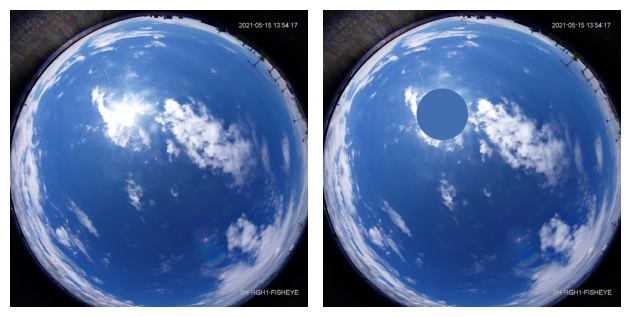

In [33]:
frame = cv2.imread("images/afternoon1.png")

tz = dateutil.tz.gettz('Europe/Vienna')  
observer = ephem.Observer()
observer.lat = str(latitude)
observer.lon = str(longitude)
observer.date = datetime.datetime(2021, 5, 15, 13, 54, 17, tzinfo = tz) # <-- add time of frame here

sun = ephem.Sun()
sun.compute(observer)

azimuth_rad = float(sun.az)
zenith_rad = math.radians(90) - float(sun.alt)

frame_height, frame_width, _ = frame.shape
cx = frame_width / 2
cy = frame_height / 2

x_pos = cx - fisheye_radius * math.sin(azimuth_rad) * zenith_rad / math.radians(fisheye_half_fov) * -1
y_pos = cy + fisheye_radius * math.cos(azimuth_rad) * zenith_rad / math.radians(fisheye_half_fov)

# Correct for orientation of camera (south is assumed to be top of the frame)
x_centered = x_pos - cx
y_centered = y_pos - cy
x_rotated = x_centered * math.cos(theta) - y_centered * math.sin(theta) + cx
y_rotated = x_centered * math.sin(theta) + y_centered * math.cos(theta) + cy

# Draw circle at sun's position on the video frame
frame_masked = frame.copy()
cv2.circle(frame_masked, (int(x_rotated), int(y_rotated)), solar_mask_radius, (178, 110, 67), -1);

# Indicate where south is on the frame
x_text = int(cx + (fisheye_radius-150) * np.cos(np.radians(-90)+theta))
y_text = int(cy + (fisheye_radius-150) * np.sin(np.radians(-90)+theta))
cv2.putText(frame_masked, "S", (int(x_text), int(y_text)), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2, cv2.LINE_AA)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame_masked_rgb = cv2.cvtColor(frame_masked, cv2.COLOR_BGR2RGB)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(frame_rgb)
ax1.axis('off')
ax2.imshow(frame_masked_rgb)
ax2.axis('off')
fig.tight_layout()
plt.show()

The sharp edges of the mask may be problematic for background subtraction. If so, we can blur around the region of the mask. Would be good to have this as a parameter where we can toggle blur on or off.

Note - there may be a more efficient ways of doing this! Here we copy the entire frame with mask then apply a Gaussian blur across the whole of the copied frame then alpha blend between the two around the region of the mask.  Blur amounts could be tweaked probably as well but this is a starting point.

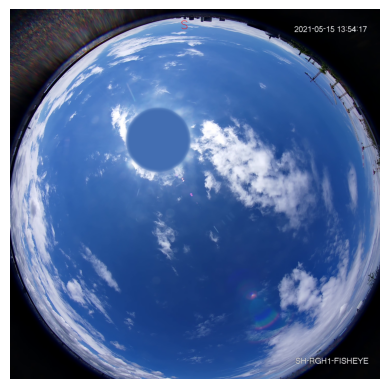

In [34]:
# Copy of frame but blurred
blurred = cv2.GaussianBlur(frame_masked, (61,61), 11)

mask = np.zeros((frame_height,frame_width), np.uint8)
cv2.circle(mask, (int(x_rotated), int(y_rotated)), solar_mask_radius+10, (255, 255, 255), -1)
mask = cv2.GaussianBlur(mask, (51,51),11 )

blended = alphaBlend(frame_masked, blurred, mask)

RGB_img = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(RGB_img)
plt.axis('off')
plt.show()

We can show the path of the sun with markers for each hour in the day from sunrise to sunset. Note below that the points do not extend to the horizon so perhaps the parameters for the fisheye and/or method here needs a bit more work.

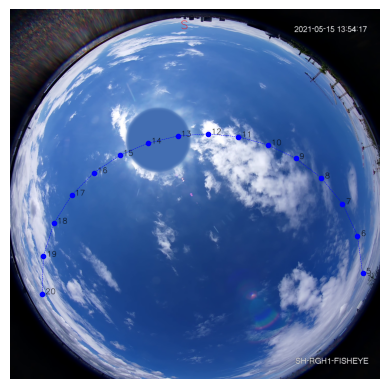

In [35]:
start_time = datetime.datetime(2021, 5, 15, 5, 15, 0, tzinfo = tz)
end_time = datetime.datetime(2021, 5, 15, 20, 26, 0, tzinfo = tz)

# Create an array of times to use for calculations
times = pd.date_range(start_time, end_time, freq='1H') # every 1H or 30T mins

x_positions = []
y_positions = []

# Loop through each time and calculate the position of the sun
for time in times:

    observer = ephem.Observer()
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = time

    sun = ephem.Sun()
    sun.compute(observer)

    azimuth_rad = float(sun.az)
    zenith_rad = math.radians(90) - float(sun.alt)

    x_pos = cx - fisheye_radius * math.sin(azimuth_rad) * zenith_rad / math.radians(fisheye_half_fov) * -1
    y_pos = cy + fisheye_radius * math.cos(azimuth_rad) * zenith_rad / math.radians(fisheye_half_fov)

    x_centered = x_pos - cx
    y_centered = y_pos - cy
    x_rotated = x_centered * math.cos(theta) - y_centered * math.sin(theta) + cx
    y_rotated = x_centered * math.sin(theta) + y_centered * math.cos(theta) + cy

    x_positions.append(x_rotated)
    y_positions.append(y_rotated)

    cv2.putText(RGB_img, str(time.hour), (int(x_rotated+25), int(y_rotated+5)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)

# Plot the line showing the path of the sun
# plt.figure(figsize=(8, 8))
plt.imshow(RGB_img)
plt.plot(x_positions, y_positions, 'blue', linewidth=0.3, marker='o', linestyle='--', markersize=3)
plt.axis('off')
plt.show()

## Moon mask

The approach for the moon is the same except using a different function in PyEphem. 

We can also reduce the size of the circular mask. 

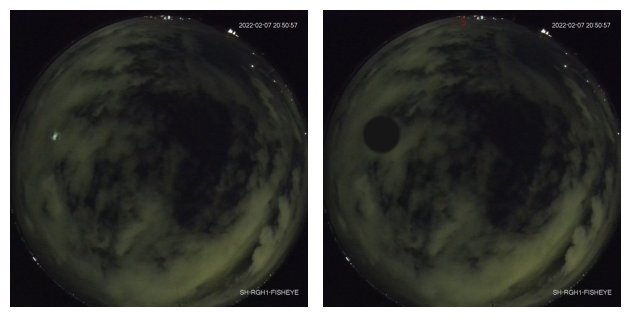

In [36]:
frame = cv2.imread("images/night4.png")

frame_height, frame_width, _ = frame.shape
cx = frame_width / 2
cy = frame_height / 2

tz = dateutil.tz.gettz('Europe/Vienna')  
observer = ephem.Observer()
observer.lat = str(latitude)
observer.lon = str(longitude)
observer.date = datetime.datetime(2022, 2, 7, 20, 50, 51, tzinfo = tz) # <-- add time of frame here

moon = ephem.Moon()
moon.compute(observer)

azimuth_rad = float(moon.az)
zenith_rad = math.radians(90) - float(moon.alt)

x_pos = cx - fisheye_radius * math.sin(azimuth_rad) * zenith_rad / math.radians(fisheye_half_fov) * -1
y_pos = cy + fisheye_radius * math.cos(azimuth_rad) * zenith_rad / math.radians(fisheye_half_fov)

x_center = x_pos - cx
y_center = y_pos - cy
x_rotated = x_center * math.cos(theta) - y_center * math.sin(theta) + cx
y_rotated = x_center * math.sin(theta) + y_center * math.cos(theta) + cy

# Draw circle at moon's position on the video frame
frame_masked = frame.copy()
cv2.circle(frame_masked, (int(x_rotated), int(y_rotated)), moon_mask_radius, (22,22,22), -1)

# Indicate where south is on the frame
x_text = int(cx + (fisheye_radius-150) * np.cos(np.radians(-90)+theta))
y_text = int(cy + (fisheye_radius-150) * np.sin(np.radians(-90)+theta))
cv2.putText(frame_masked, "S", (int(x_text), int(y_text)), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2, cv2.LINE_AA)

# Blur
blured = cv2.GaussianBlur(frame_masked, (61,61), 11)
mask = np.zeros((frame_height,frame_width), np.uint8)
cv2.circle(mask, (int(x_rotated), int(y_rotated)), solar_mask_radius+10, (255, 255, 255), -1)
mask = cv2.GaussianBlur(mask, (51,51),11 )

blended = alphaBlend(frame_masked, blured, mask)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame_masked_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(frame_rgb)
ax1.axis('off')
ax2.imshow(frame_masked_rgb)
ax2.axis('off')
fig.tight_layout()
plt.show()

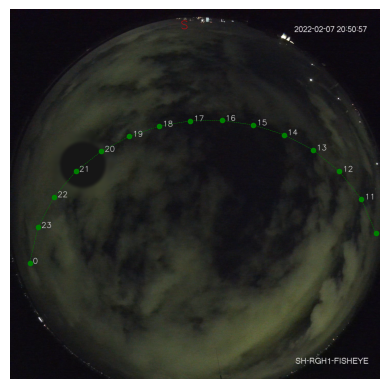

In [37]:
start_time = datetime.datetime(2022, 2, 7, 10, 7, 51, tzinfo = tz)
end_time = datetime.datetime(2022, 2, 8, 0, 44, 51, tzinfo = tz)

# Create an array of times to use for calculations
times = pd.date_range(start_time, end_time, freq='1H') # every 1H or e.g. 30T mins

x_positions = []
y_positions = []

for time in times:

    observer = ephem.Observer()
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = time

    moon = ephem.Moon()
    moon.compute(observer)

    azimuth_rad = float(moon.az)
    zenith_rad = math.radians(90) - float(moon.alt)

    x_pos = cx - fisheye_radius * math.sin(azimuth_rad) * zenith_rad / math.radians(fisheye_half_fov) * -1
    y_pos = cy + fisheye_radius * math.cos(azimuth_rad) * zenith_rad / math.radians(fisheye_half_fov)

    x_centered = x_pos - cx
    y_centered = y_pos - cy
    x_rotated = x_centered * math.cos(theta) - y_centered * math.sin(theta) + cx
    y_rotated = x_centered * math.sin(theta) + y_centered * math.cos(theta) + cy

    x_positions.append(x_rotated)
    y_positions.append(y_rotated)

    cv2.putText(frame_masked_rgb, str(time.hour), (int(x_rotated+25), int(y_rotated+5)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)

# Plot the line showing the path of the sun
# plt.figure(figsize=(8, 8))
plt.imshow(frame_masked_rgb)
plt.plot(x_positions, y_positions, 'green', linewidth=0.3, marker='o', linestyle='--', markersize=3)
plt.axis('off')
plt.show()

# Summary

Masking the sun and moon may be a useful tool for reducing false positives and improving tracking. In the night example above it is clear to see how a mask could improve things. However, in significant partial cloud and diffuse light (as shown in the image at the start of this script) matters are more complicated and masking would only likely help a little.

In terms of computation - the masks would only needs to be redrawn every few minutes so will not be demanding.

The optimal size of the mask has not been addressed here but 3 x times the size of the sun or moon might be a good place to start. Also for mask colour a reasonable approach may be to auto sample the most common colour in the frame and use that (what is attempted manually above)

The next step should look to evaluating the effectiveness of this approach.